In [66]:
from langchain_groq import ChatGroq
from CONFIG import GROQ_MODEL, OPENAI_EMBEDDED_MODEL
from langchain_openai import OpenAIEmbeddings
from pydantic import BaseModel, StrictBool, Field
from typing import List, TypedDict, Literal
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from langgraph.graph import START, END, StateGraph
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

In [67]:
load_dotenv()
llm = ChatGroq(model=GROQ_MODEL)
embedded_model = OpenAIEmbeddings(model=OPENAI_EMBEDDED_MODEL)

In [68]:
pdfs = (
    PyPDFLoader(file_path="A:\AI_Projects_Practice\Self-RAG\KaravanTech_Company_Policies.pdf").load() + 
    PyPDFLoader(file_path="A:\AI_Projects_Practice\Self-RAG\KaravanTech_Company_Profile.pdf").load() + 
    PyPDFLoader(file_path="A:\AI_Projects_Practice\Self-RAG\KaravanTech_Products_and_Pricing.pdf").load()
)

In [69]:
splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=30).split_documents(pdfs)
vector_store = FAISS.from_documents(splitter, embedded_model)
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [70]:
class STATE(TypedDict):
    question: str
    retrieve_or_not: bool

    docs: List[Document]
    
    answer: str

In [71]:
class should_retrive_or_not(BaseModel):
    retrieve_or_not: bool = Field(..., description="true if question needs document retrieval, false if answerable from general knowledge")

decision_prompt = ChatPromptTemplate.from_messages(
	[
	(
		"system",
		"You decide whether retrieval is needed.\n"
		"Return JSON that matches this schema:\n"
		"{{'retrieve_or_not': boolean}}\n\n"
		"Guidelines:\n"
		"- retrieve_or_not=True if answering requires specific facts, citations, or info likely not in the model.\n"
		"- retrieve_or_not=False for general explanations, definitions, or reasoning that doesn't need sources.\n"
		"- If unsure, choose True."
	),
	(
		"human",
		"user question is: {question}"
	)
	]
)

output = llm.with_structured_output(should_retrive_or_not)

def decision_node(state: 'STATE'):
	decision: should_retrive_or_not = output.invoke(decision_prompt.format_messages(question=state['question']))       
	return {'retrieve_or_not': decision.retrieve_or_not}

In [72]:
direct_generate_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer the question using only your general knowledge.\n"
            "Do NOT assume access to external documents.\n"
            "If you are unsure or the answer requires specific sources, say:\n"
            "I don't know based on my general knowledge. "
        ),
        ("human", "{question}")
    ]
)

def direct_generate(state: 'STATE'):
    answer = llm.invoke(direct_generate_prompt.format_messages(question=state['question']))
    return {"answer": answer.content}

In [86]:
def retriever_node(state: 'STATE'):
    return {'docs': retriever.invoke(state['question'])}

In [87]:
def router_node(state: STATE) -> Literal['direct_generate', 'retriever_node']:
    if state['retrieve_or_not']:
        return 'retriever_node'
    return 'direct_generate'

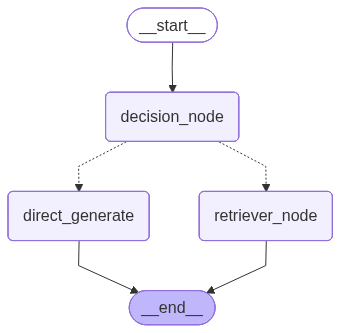

In [88]:
graph = StateGraph(STATE)

graph.add_node('decision_node', decision_node)
graph.add_node('retriever_node', retriever_node)
graph.add_node('direct_generate', direct_generate)

graph.add_edge(START, 'decision_node')
graph.add_conditional_edges(
    'decision_node',
    router_node,
    {
        'retriever_node': 'retriever_node',
        'direct_generate': 'direct_generate'
    }
)

graph.add_edge("retriever_node", END)
graph.add_edge("direct_generate", END)

gra = graph.compile()
gra

In [89]:
gra.invoke({'question': 'transformer in DEEPLEARNING'})

{'question': 'transformer in DEEPLEARNING',
 'retrieve_or_not': False,
 'answer': 'In deep learning, a Transformer is a type of neural network architecture introduced in 2017 by Vaswani et al. in the paper "Attention Is All You Need". It\'s primarily designed for sequence-to-sequence tasks, such as machine translation, text summarization, and image captioning.\n\nThe Transformer model relies heavily on self-attention mechanisms, which allow it to weigh the importance of different input elements relative to each other. This is different from traditional recurrent neural networks (RNNs) and convolutional neural networks (CNNs), which rely on recurrent connections and convolutional filters, respectively.\n\nKey components of a Transformer:\n\n1. **Self-Attention Mechanism**: This allows the model to attend to different parts of the input sequence simultaneously and weigh their importance.\n2. **Encoder-Decoder Architecture**: The Transformer consists of an encoder and a decoder. The encod

In [ ]:
gra.invoke({'question': 'who is the CEO karavantech'})
gra.invoke({'question': 'what is machine learning'})